In [1]:
import numpy as np
from matplotlib import pyplot as plt

from src.channel_blocks import ChannelBlocks
from src.channel_simulation import ChannelSimulator
from src.split_step_fourier import SplitStepFourier
from src.visualizer import Visualizer

# Channel Simulation
here starts the actual channel simulator code.

we will demonstrate the following block diagram


In [ ]:
class BlockDiagram:
    """
  msg -> [modulation] -> [oversample + pulse-shape] -> [pre-equalize] -> [INFT] ⤵
                                                                            [channel]
  msg <- [Demodulation]  <-   [   match-filter   ]  <-  [equalize]    <- [NFT]  /
    """

In [2]:
cs = ChannelSimulator(m_qam=16,
                      num_symbols=512,
                      normalization_factor=0.1,
                      channel_func=SplitStepFourier(),
                      verbose=True)

cb = ChannelBlocks(cs.verbose)
np.set_printoptions(threshold=250)

## 0) Generate message

In [3]:

cs.x[0] = cb.generate_message(cs.length_of_msg, cs.sps)


_______________________________________________
message before channel - len=2048
[[0 1 1 0]
 [1 0 1 1]
 [1 1 0 0]
 ...
 [0 1 1 1]
 [0 1 0 1]
 [0 0 0 0]]




## 1) Modulation


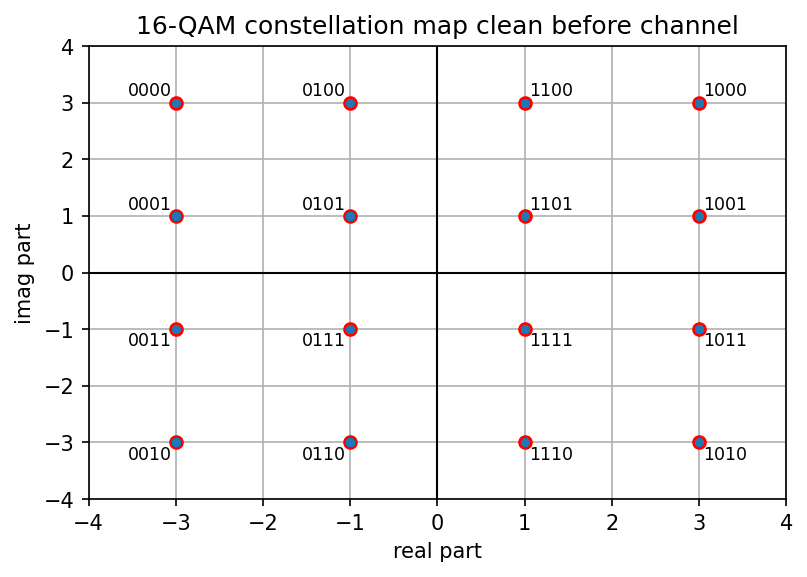

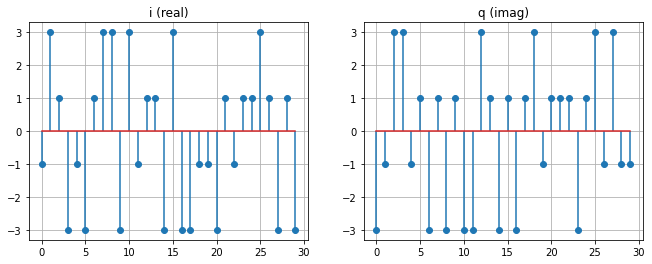

num of symbols = 512


In [4]:
cs.x[1], cs.modem = cb.modulate(cs.x[0], cs.m_qam)

### 1.1) Test demod

In [5]:
x0_reconst = cs.modem.demodulate(cs.x[1])
num_errors = (x0_reconst != cs.x[0]).sum()
if cs.verbose:
    Visualizer.print_bits(x0_reconst, cs.sps, 'test reconstructed msg')
    Visualizer.print_bits(cs.x[0], cs.sps, 'message before channel')
    print(f'ber = {num_errors / cs.length_of_msg} = {num_errors}/{cs.length_of_msg}')


_______________________________________________
test reconstructed msg - len=2048
[[0 1 1 0]
 [1 0 1 1]
 [1 1 0 0]
 ...
 [0 1 1 1]
 [0 1 0 1]
 [0 0 0 0]]



_______________________________________________
message before channel - len=2048
[[0 1 1 0]
 [1 0 1 1]
 [1 1 0 0]
 ...
 [0 1 1 1]
 [0 1 0 1]
 [0 0 0 0]]


ber = 0.0 = 0/2048


## 2) over sampling
over sample a vector by factor, using zero padding in between each sample

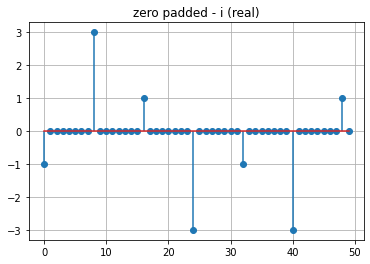

vec length = 4089, over_sampling period = 8


In [6]:
cs.x[2] = cb.over_sample(cs.x[1], cs.over_sampling)

## 3) Pulse Shaping
* convolve with filter: rrc
* fliter length is chosen such that x afterwards will be length power of two (closest above)

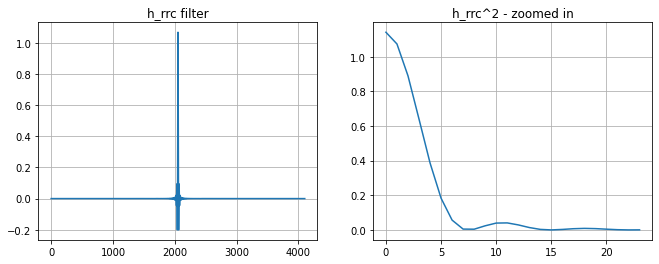

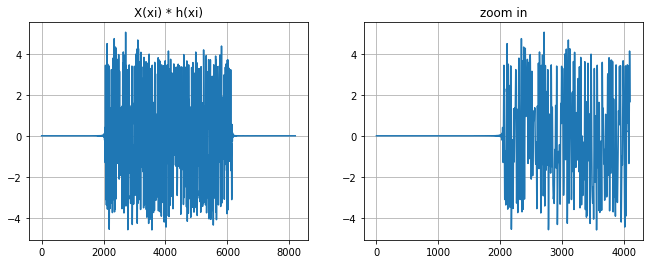

filter len = 4104, signal len = 8192


In [7]:
cs.x[3], cs.L_rrc, cs.h_rrc = cb.pulse_shape(cs.x[2], cs.roll_off,cs.over_sampling,cs.Ts)

### 3.1 Test: reconstruction
before we move on, lets try to restore this using match filter


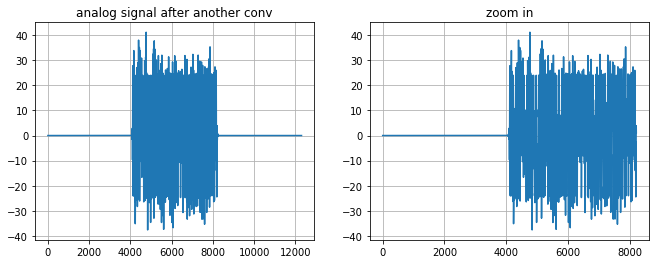

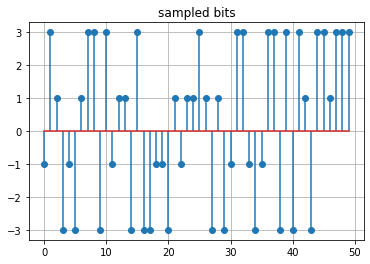

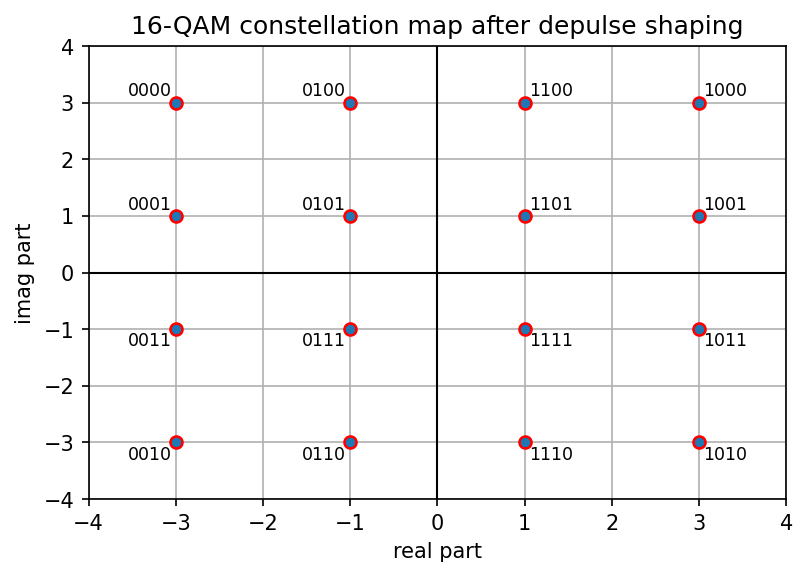

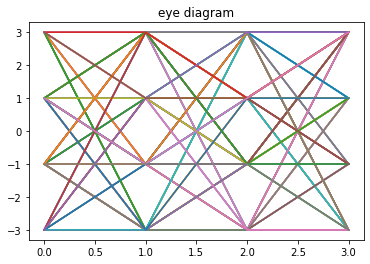

In [8]:
xx41 = np.convolve(cs.x[3], cs.h_rrc)

# sampling the analog vector into discrete bits
L_rrc = len(cs.h_rrc)
start = L_rrc
stop = - L_rrc + cs.over_sampling
step = cs.over_sampling
xx42 = xx41[start:stop:step] / cs.over_sampling

if cs.verbose:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
    Visualizer.my_plot(np.real(xx41), name='analog signal after another conv', ax=ax1, hold=1)
    Visualizer.my_plot(np.real(xx41[:L_rrc * 2]), name='zoom in', ax=ax2)

    Visualizer.my_plot(np.real(xx42[0:50]), name='sampled bits', function='stem')

    Visualizer.plot_constellation_map_with_points(xx42, cs.m_qam, 'after depulse shaping')
    Visualizer.eye_diagram(xx42, sps=cs.sps)


## 4) Pre-Equalizer
*   normalize




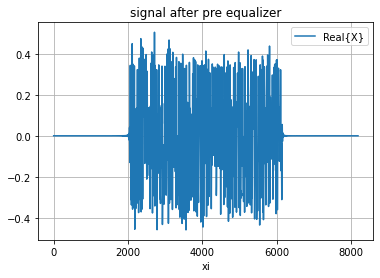

signal len = 8192


In [9]:
cs.x[4] = cb.pre_equalize(cs.x[3],cs.normalization_factor)

## 5) INFT

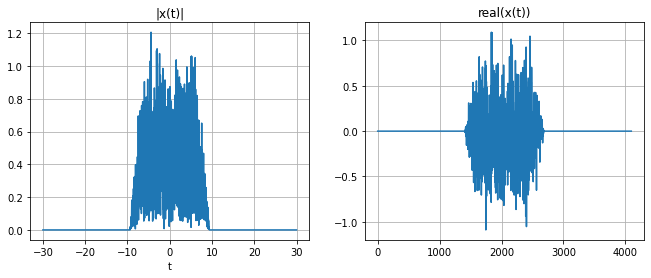

length of INFT(x) = 4096


In [10]:
cs.N_xi, cs.N_time, cs.tvec, cs.xivec, cs.BW = cb.gen_nft_params(cs.x[4],cs.Tmax)
cs.x[5] = cb.inft(cs.x[4],cs.tvec,cs.xivec)

## 6) Channel 
  (nothing)

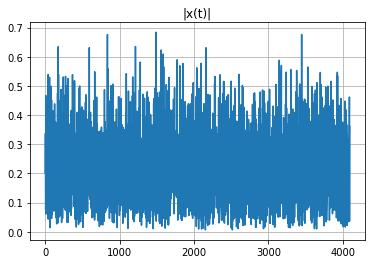

In [15]:
cs.channel_func = SplitStepFourier(
    alpha=0,
    b2=-20e-27,
    gamma=0.003,
    to=125e-12,
    steps=np.arange(0.1,1.51,0.1),
    dt=1e-12,
    h=100
)
cs.x[6] = cb.channel(cs.x[5],cs.channel_func)

## 7) NFT

In [ ]:
cs.x[7] = cb.nft(cs.x[6],cs.tvec,cs.xivec,cs.BW,cs.N_xi,cs.L_rrc,cs.x[4])

## 8) Equalizer


*   de-normalize
*   channel equalizer (nothing)



In [ ]:
cs.x[8] = cb.equalizer(cs.x[7], cs.normalization_factor)

## 9) Match Filter
convolve again with the rrc filter and sample at the over sampling period

In [ ]:
cs.x[9] = cb.match_filter(cs.x[8],cs.h_rrc,cs.L_rrc,cs.over_sampling,cs.m_qam,cs.sps)

## 10) Demodulation

In [ ]:
cs.x[10] = cb.demodulate(cs.x[9],cs.modem, cs.length_of_msg)
ber, num_errors = cb.calc_ber(cs.x[0],cs.x[10],cs.length_of_msg,cs.sps)